# Author Classifier Project

## Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import ipywidgets as widgets

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB

from sklearn import metrics

##  Import dataset

In [2]:
'''
This dataset is made up of 5-10 papers from 17 authors working in experimental economics.
A papers is marked if it is co-authored by other economics in the dataset.
'''

df = pd.read_csv(r'journal_database.csv', encoding='latin1')

In [3]:
# This line excludes coauthored papers. To turn them on, comment it out
df = df[df["Co-authored with someone in the database"]==0]

## Tokenizing and Count Vectorizing

In [4]:
# Using uni, bi, and trigrams seems to be the sweet spot
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,3),tokenizer = token.tokenize)

In [5]:
# Transforms X from scipy.sparse._csr.csr_matrix to numpy.matrix
x=df['text']

# Transforms author column from pandas.core.series.Series to numpy.ndarray
y=df['author']

## Spliting Train and Test Data

In [6]:
# Using a 70-30 test/train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## Training Several Models

In [7]:
x_train_bow = vectorizer.fit_transform(x_train)
x_train_bow = np.array(x_train_bow.todense())

In [8]:
# Model Generation Using Multinomial Naive Bayes clasifier (clf)
clf_multinomialNB = MultinomialNB().fit(x_train_bow, y_train)
clf_bernulliNB = BernoulliNB().fit(x_train_bow, y_train)
clf_gaussianNB = GaussianNB().fit(x_train_bow, y_train)
clf_complementNB = ComplementNB().fit(x_train_bow, y_train)

## Evaluting Model Accuracy

In [9]:
#converting testing samples into bag of words
x_test_bow = vectorizer.transform(x_test)
x_test_bow = np.array(x_test_bow.todense())

# Fitting the models
clf_multinomialNB_predicted = clf_multinomialNB.predict(x_test_bow)
clf_bernulliNB_predicted = clf_bernulliNB.predict(x_test_bow)
clf_gaussianNB_predicted = clf_gaussianNB.predict(x_test_bow)
clf_complementNB_predicted = clf_complementNB.predict(x_test_bow)

# Comparing predictions with actual clasifications
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, clf_multinomialNB_predicted))
print("BernoulliNB Accuracy:",metrics.accuracy_score(y_test, clf_bernulliNB_predicted))
print("GaussianNB Accuracy:",metrics.accuracy_score(y_test, clf_gaussianNB_predicted))
print("ComplementNB Accuracy:",metrics.accuracy_score(y_test, clf_complementNB_predicted))

MultinomialNB Accuracy: 0.3125
BernoulliNB Accuracy: 0.0
GaussianNB Accuracy: 0.3125
ComplementNB Accuracy: 0.53125


## Determining how accuracy changes when we accept the top n authors

In [10]:
def remove_x_y_by_y(x, y, y_value):
    """
    
    Helper function for lenient_prediction function.
    
    Remove all x values that line up with a certain y value,
    as well as the corresponding y values.

    Args:
        x (pandas.Series or dict): x dataset with shared indices with y.
        y (pandas.Series or dict): y dataset with shared indices with x.
        y_value (float or int): The y value to remove x and y values for.

    Returns:
        Tuple of pandas.Series or dict: A tuple of two datasets:
        - x_new: A new x dataset with the same indices as the input x dataset,
          but with all x values that line up with the given y value removed.
        - y_new: A new y dataset with the same indices as the input y dataset,
          but with all y values that equal the given y value removed.
    """
    import pandas as pd
    
    # Convert dictionaries to pandas Series for easier manipulation
    if isinstance(x, dict):
        x = pd.Series(x)
    if isinstance(y, dict):
        y = pd.Series(y)

    # Create a mask for indices where y equals y_value
    mask = y == y_value

    # Use the mask to remove x and y values that line up with y_value
    x_new = x[~mask]
    y_new = y[~mask]

    # Convert back to a dictionary if the input was a dictionary
    if isinstance(x, dict):
        x_new = x_new.to_dict()
    if isinstance(y, dict):
        y_new = y_new.to_dict()

    return x_new, y_new

In [11]:
def lenient_prediction(num_predictions, model, ngram):
    '''
    iteratively remove instances from the training data that were predicted incorrectly 
    and retrain the model on the updated dataset. The accuracy is 
    printed for each iteration, considering an increasing number of predictions.
    
    arguments x and y are the testing data
    assumes data has already been partitioned into test and training splits
    '''
    accuracy = []
    vectorizer = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,ngram),tokenizer = token.tokenize)
    
    x_train_bow = vectorizer.fit_transform(x_train)
    x_train_bow = np.array(x_train_bow.todense())
    
    model.fit(x_train_bow, y_train)
    x_bow = np.array(vectorizer.transform(x_test).todense())
    predicted_lenient = list(model.predict(x_bow))
    
    x_array, y_array = x_test.to_list(), y_test.to_list()

    predictions = [[0 for _ in range(len(x_test))] for _ in range(num_predictions)]  # define prediction matrix
    predictions[0] = list(predicted_lenient)
    
    print(f"Accuracy taking the top prediction with ngram = {ngram}:", metrics.accuracy_score(y_test, predicted_lenient))
    accuracy.append(metrics.accuracy_score(y_test, predicted_lenient))
    
    for i in range(num_predictions-1):
        for j in range(len(y_test)):
            if predicted_lenient[j] != y_array[j]:  # if first prediction is wrong
                x_new, y_new = x_train, y_train
                for x in range(i + 1):
                    x_new, y_new = remove_x_y_by_y(x_new, y_new, predictions[x][j])  # remove predicted author from the dataset

                x_new_bow = vectorizer.transform(x_new)  # retrain the dataset
                x_new_bow = np.array(x_new_bow.todense())

                new_model = model.fit(x_new_bow, y_new)

                retry_bow = vectorizer.transform([x_array[j]])  # Go back to the input that was originally wrong, and retry it
                retry_bow = np.array(retry_bow.todense())

                predicted_lenient[j] = new_model.predict(retry_bow)[0]  # replace in the predicted list

            predictions[i + 1][j] = predicted_lenient[j]  # update predictions matrix

        print(f"Accuracy taking the top {i + 2} predictions with ngram = {ngram}:", metrics.accuracy_score(y_test, predicted_lenient))
        accuracy.append(metrics.accuracy_score(y_test, predicted_lenient))
    return(accuracy)

In [12]:
%%time

accuracy = lenient_prediction(6, ComplementNB(), 1)
print(accuracy)

Accuracy taking the top prediction with ngram = 1: 0.5
Accuracy taking the top 2 predictions with ngram = 1: 0.6875
Accuracy taking the top 3 predictions with ngram = 1: 0.71875
Accuracy taking the top 4 predictions with ngram = 1: 0.75
Accuracy taking the top 5 predictions with ngram = 1: 0.78125
Accuracy taking the top 6 predictions with ngram = 1: 0.78125
[0.5, 0.6875, 0.71875, 0.75, 0.78125, 0.78125]
CPU times: user 34.4 s, sys: 337 ms, total: 34.8 s
Wall time: 9.15 s


In [13]:
'''
To generate the model_probability_matricies, uncomment the code below. It takes about an hour and a half to run, however.
To make compiling this notebook easier, I've just defined the dictionary in the next code block.
'''

# %%time

# ngram_range = 6
# leniency_range = 6
# models = {ComplementNB(), MultinomialNB(), BernoulliNB(), GaussianNB()}

# model_probability_matricies = {}

# for model in models:
#     model_probability_matricies[str(model)] = []
#     for i in range(1, ngram_range+1):
#         model_probability_matricies[str(model)].append(lenient_prediction(leniency_range, model, i))
#         print(model_probability_matricies[str(model)])
# print(model_probability_matricies)

"\nTo generate the model_probability_matricies, uncomment the code below. It takes about an hour and a half to run, however.\nTo make compiling this notebook easier, I've just defined the dictionary in the next code block.\n"

In [14]:
model_probability_matricies = {str(ComplementNB()): [[0.5, 0.6875, 0.71875, 0.75, 0.78125, 0.78125], [0.53125, 0.6875, 0.71875, 0.71875, 0.71875, 0.75], [0.53125, 0.65625, 0.6875, 0.6875, 0.6875, 0.71875], [0.53125, 0.65625, 0.65625, 0.65625, 0.65625, 0.6875], [0.53125, 0.65625, 0.65625, 0.65625, 0.65625, 0.65625], [0.53125, 0.625, 0.625, 0.65625, 0.65625, 0.65625]], str(BernoulliNB()): [[0.03125, 0.03125, 0.15625, 0.21875, 0.25, 0.34375], [0.0, 0.03125, 0.0625, 0.125, 0.25, 0.25], [0.0, 0.03125, 0.0625, 0.125, 0.25, 0.25], [0.0, 0.03125, 0.0625, 0.125, 0.25, 0.25], [0.0, 0.03125, 0.0625, 0.125, 0.21875, 0.25], [0.0, 0.03125, 0.0625, 0.125, 0.1875, 0.25]], str(MultinomialNB()): [[0.34375, 0.46875, 0.46875, 0.53125, 0.53125, 0.625], [0.3125, 0.40625, 0.40625, 0.40625, 0.4375, 0.4375], [0.3125, 0.40625, 0.40625, 0.40625, 0.4375, 0.4375], [0.3125, 0.40625, 0.40625, 0.40625, 0.4375, 0.4375], [0.3125, 0.40625, 0.40625, 0.40625, 0.4375, 0.4375], [0.3125, 0.40625, 0.40625, 0.40625, 0.40625, 0.4375]], str(GaussianNB()): [[0.28125, 0.40625, 0.4375, 0.4375, 0.4375, 0.46875], [0.3125, 0.40625, 0.46875, 0.5, 0.5, 0.53125], [0.3125, 0.40625, 0.46875, 0.5, 0.5, 0.53125], [0.3125, 0.40625, 0.5, 0.5, 0.5, 0.53125], [0.3125, 0.40625, 0.5, 0.5, 0.5, 0.53125], [0.3125, 0.40625, 0.5, 0.5, 0.5, 0.53125]]}

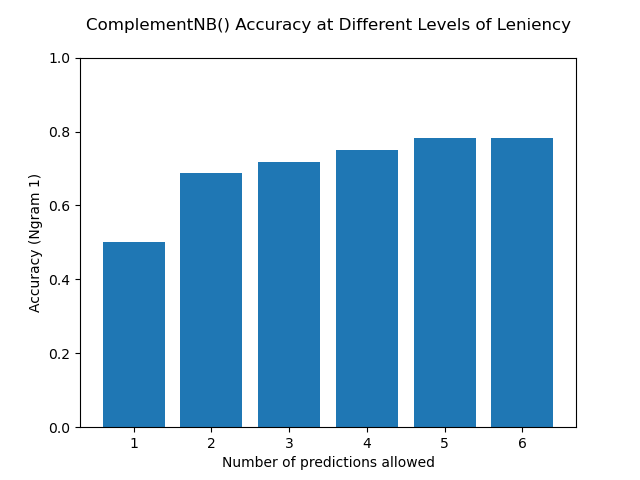

In [15]:
"""
This code generates an interactive plot to visualize the accuracy of different machine learning models
at different levels of leniency, using n-grams as the input feature.

The plot displays the accuracy values on the y-axis and the number of predictions allowed on the x-axis.
The user can select a specific model and n-gram value using the dropdown and slider, respectively.
The plot updates dynamically when the user changes the model or n-gram selection.

Note: Ensure that the necessary libraries (nltk, pandas, numpy, sklearn, matplotlib, IPython, ipywidgets) are imported.
"""

# Enable interactive plots
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Sample two-dimensional matrix
matrix = np.array(model_probability_matricies[str(MultinomialNB())])

# Generate x-axis values (element index)
x = np.arange(matrix.shape[1]) + 1

# Initialize the figure and axis
fig, ax = plt.subplots()

# Function to update the plot when a different array is selected
def update_plot(change):
    # Retrieve the selected values from the dropdown and slider
    selected_ngram = slider.value
    selected_model = dropdown.value
    
    # Get the matrix based on the selected model
    matrix = np.array(model_probability_matricies[selected_model])
    
    # Clear the previous bars and labels
    ax.clear()
    
    # Plot the new bars
    bars = ax.bar(x, matrix[selected_ngram-1], align='center')
    
    # Set the y-axis limits
    ax.set_ylim(0, 1)
    
    # Update the plot labels and title
    ax.set_xlabel('Number of predictions allowed')
    ax.set_ylabel(f'Accuracy (Ngram {selected_ngram})')
    ax.set_title(f'{selected_model} Accuracy at Different Levels of Leniency', pad=20)
    
    # Remove the duplicate "Figure 1" label from the plot
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False
    
    # Update the figure
    fig.canvas.draw()
    
    # Update the dropdown label
    dropdown.description = 'Model:'

# Create a dropdown to select different models
dropdown = widgets.Dropdown(options=list(model_probability_matricies.keys()), value=str(ComplementNB()), description='Model:')

# Create a slider to select different n-grams
slider = widgets.IntSlider(value=1, min=1, max=matrix.shape[0], description='Ngrams:', readout=False)

# Update the plot when the dropdown or slider value changes
dropdown.observe(update_plot, names='value')
slider.observe(update_plot, names='value')

# Initialize the plot with the initial values
update_plot({'new': 0})

# Display the dropdown, slider, and the plot
widgets.VBox([dropdown, slider, fig.canvas])


## Testing on outside documents

In [16]:
#1 Exley
exley_file = open("test_documents/Exley_test.txt", "r")
exley_test = str(exley_file.read())
exley_file.close()

exley_test_BoW=vectorizer.transform([exley_test])
exley_test_BoW=np.array(exley_test_BoW.todense())

# using the complementNB model as that one performmed best in the test/train trials
clf_complementNB_outside_one = clf_complementNB.predict(exley_test_BoW)

print("ComplementNB outside assignment:",clf_complementNB_outside_one)

ComplementNB outside assignment: ['Christine L. Exley']


In [17]:
#2 Oprea
oprea_file = open("test_documents/oprea_test.txt", "r")
oprea_test = str(oprea_file.read())
oprea_file.close()
oprea_test_BoW=vectorizer.transform([oprea_test])
oprea_test_BoW=np.array(oprea_test_BoW.todense())
clf_complementNB_outside_one = clf_complementNB.predict(oprea_test_BoW)
print("ComplementNB outside assignment:",clf_complementNB_outside_one)

ComplementNB outside assignment: ['Ryan Oprea']


In [18]:
#3 Kessler
kessler_file = open("test_documents/kessler_test.txt", "r")
kessler_test = str(kessler_file.read())
kessler_file.close()
kessler_test_BoW=vectorizer.transform([kessler_test])
kessler_test_BoW=np.array(kessler_test_BoW.todense())
clf_complementNB_outside_one = clf_complementNB.predict(kessler_test_BoW)
print("ComplementNB outside assignment:",clf_complementNB_outside_one)

ComplementNB outside assignment: ['Judd B. Kessler']


In [19]:
#4 Yariv - the only one that the complementNB model gets wrong. Note that this is two pages of a book review.
#The other three samples are more academic. It makes sense that the model would do worse with this one.
Yariv_file = open("test_documents/Yariv_test.txt", "r")
Yariv_test = str(Yariv_file.read())
Yariv_file.close()
Yariv_test_BoW=vectorizer.transform([Yariv_test])
Yariv_test_BoW=np.array(Yariv_test_BoW.todense())
clf_complementNB_outside_one = clf_complementNB.predict(Yariv_test_BoW)
print("ComplementNB outside assignment:",clf_complementNB_outside_one)

ComplementNB outside assignment: ['Ignacio Esponda']
